# YouTube Live Capture
> This module is used to capture images from YouTube live.

In [ ]:
#| default_exp ytlive

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
from datetime import datetime
from IPython.display import Image, display
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pytesseract
import time
import yt_dlp as youtube_dl

# Näkymä Helsingistä location list

In [ ]:
#|export
nakyma_helsinki_known_places = [
    "Olympiaterminaali",
    "Etelasatama",
    #"Eteläsatama",  # fixup
    "Eteladsatama", # fixup
    "Presidentinlinna",
    "Tuomiokirkko",
    "Kauppatori",
    "Kauppator",    # fixup   
    "Torni",
    "Valkosaari",
]

# YouTube Capture Experiment

In [ ]:
#|export
nakyma_helsinkigista_youtube_live_url = "https://www.youtube.com/watch?v=LMZQ7eFhm58"
ydl_opts = {
    'cookiefile': "cookies.txt",  # Path to the exported cookies file,  # Use cookies for authentication
    'download': False  # Set to True if you want to download
}

In [ ]:
#|eval: false
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    info = ydl.extract_info(nakyma_helsinkigista_youtube_live_url, download=False)
    for o in info['formats']:
        if o['resolution'] == '1280x720':
            print(o['url'])
            break
    else:
        raise ValueError("No 1280x720 format")

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading web creator player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1730307113/ei/yQ8iZ5iHJdO-0u8P17eRmAs/ip/87.92.255.37/id/LMZQ7eFhm58.4/itag/232/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/sgovp/gir%3Dyes%3Bitag%3D136/rqh/1/hdlc/1/hls_chunk_host/rr5---sn-qo5-ixas.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/playlist_duration/3600/manifest_duration/3600/vprv/1/playlist_type/DVR/initcwndbps/1496250/met/1730285513,/mh/l8/mm/44/mn/sn-qo5-ixas/ms/lva/mv/m/mvi/5/pl/18/rms/lva,lva/dover/13/pacing/0/short_key/1/keepalive/yes/fexp/51312688,51326931/mt/1730285070/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,sgovp,rqh,hdlc,xpc,playlist_duration,manifest_duration,vprv,playlist_type/sig/AJfQd

In [ ]:
#|export
def stream_url(ytlive_url:str, ydl_opts:dict) -> str:
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(ytlive_url, download=False)
        for o in info['formats']:
            if o['resolution'] == '1280x720':
                return o['url']
        else:
            raise ValueError("No 1280x720 format")    

In [ ]:
#|export
def show_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB for Matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axes
    plt.show()   

In [ ]:
#|export
def crop_frame(frame, crop=(0, 0, 480, 30)):
    x, y, w, h = crop
    return frame[y:y+h, x:x+w]    

In [ ]:
#|export
def frame_to_text(frame): return pytesseract.image_to_string(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).strip()

In [ ]:
#|export
def known(txt:str, known_places:str) -> str:
    "try to find one of `known_places` are included in the given `txt`"
    for o in known_places:
        #print(o, "in", txt)
        if o in txt:
            return o
    raise Exception("No place specified")

In [ ]:
assert known("Torninnnnnn", nakyma_helsinki_known_places)=="Torni"

In [ ]:
#|export
def meta(frame, known_places=nakyma_helsinki_known_places, printing=False):
    "Withdraw meta data, datetime & place"
    # "04.10.2024  14:53:49  Kauppatori", Original format
    txt = frame_to_text(frame)
    if printing==True: print(txt)
    dt = datetime.strptime(txt[:19],"%d.%m.%Y %H:%M:%S")
    pl = known(txt[20:], known_places)
    pl = pl.replace("Eteladsatama", "Etelasatama") # fixup
    pl = pl.replace("ä", "a")                      # fixup
    pl = pl.replace("kauppator", "kauppatori")     # fixup
    return dt, pl

In [ ]:
#|export
def fname(prefix, dt, pl): return f"""{prefix}{dt.strftime("%Y.%m.%d_%H:%M:%S")}_{pl}.jpg"""

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading web creator player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information


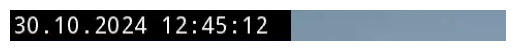

10.2024 1
10.2024 1
time data '10.2024 1' does not match format '%d.%m.%Y %H:%M:%S'


In [ ]:
#| eval: false
url = stream_url(nakyma_helsinkigista_youtube_live_url, ydl_opts)
cap = cv2.VideoCapture(url)
ret, frame = cap.read()
if ret:
    show_frame(crop_frame(frame))
    print(frame_to_text(crop_frame(frame)))
    try:
        print(fname("cap_", *meta(crop_frame(frame), printing=True)))
    except Exception as e:
        print(e)
else:
    print("Failed to capture frame.")

In [ ]:
#|export
def capture_youtube_live_frame(youtube_live_url:str=nakyma_helsinkigista_youtube_live_url):
    "Capture a frame from the given YouTube Live URL and save into a JPEG file"

    url = stream_url(youtube_live_url, ydl_opts)
    cap = cv2.VideoCapture(url)
    ret, frame = cap.read()
    #show_frame(crop_frame(frame))
    if ret==False:
        raise Exception("Failed to capture frame.")
    try:        
        path = Path("../data")/fname("cap_", *meta(crop_frame(frame), printing=True))
    except:
        path = Path("../data")/fname("fail_", datetime.now(), "nowhere")
    path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(path, frame)
    return path

In [ ]:
#|eval: false
file = capture_youtube_live_frame()
file

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading web creator player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
30.10.2024 12:45:22 Tuomiokirkko |


Path('../data/cap_2024.10.30_12:45:22_Tuomiokirkko.jpg')

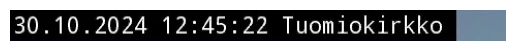

In [ ]:
#|eval: false
def crop_image(path, crop=(0, 0, 480, 30)): return Image.open(path).crop(crop)
def show_image(path):
    plt.imshow(crop_image(path))
    plt.axis('off')
    plt.show()

show_image(file)

# Extract meta data from an image file

In [ ]:
#|eval: false
try:
    fname("cap_", *meta(files[1]))
except:
    pass

## Rename files with meta info

"cap_2024.10.04_14:56:49_Presidentinlinna"

"cap_2024.10.06_19:04:14_Kauppatori"

"cap_2024.10.06_20:08:29_Kauppatori"

In [ ]:
#|eval: false
for i, o in enumerate(glob.glob("../data/f*.jpg")):
    try:
        new = Path("../data")/fname("cap_", *meta(o, True))
        print(i, o, " -> ", new)
        os.rename(o, new)
    except Exception as e:
        print(o)

../data/fail_2024.10.30_12:37:43_nowhere.jpg
../data/frame_1730210769.jpg
../data/frame_1730275818.jpg
../data/frame_1730216457.jpg
../data/frame_1730216703.jpg
../data/frame_1730210684.jpg
../data/frame_1730283579.jpg
../data/fail_2024.10.30_12:37:46_nowhere.jpg
../data/fail_2024.10.30_12:51:56_nowhere.jpg
../data/frame_1730210981.jpg
../data/fail_2024.10.30_12:37:49_nowhere.jpg
../data/fail_2024.10.30_12:38:06_nowhere.jpg
../data/frame_1730210632.jpg
../data/frame_1730210753.jpg
../data/frame_1730210641.jpg
../data/frame_1730275774.jpg
../data/frame_1730210660.jpg
../data/frame_1730211141.jpg
../data/fail_2024.10.30_12:37:38_nowhere.jpg
../data/fail_2024.10.30_12:38:01_nowhere.jpg
../data/frame_1730276077.jpg


In [1]:
#| hide
import nbdev; nbdev.nbdev_export()